### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Sentiment Batch Notebook
This notebook shows you how you can use the batch APIs to more efficiently process large amounts of records


## Setup
Install the necessary libraries, note that you need OCI version 2.57.0 or higher to use the batch APIs

In [ ]:
!pip install pandas
!pip install ipymarkup
!pip install matplotlib
!pip install wordcloud
!pip install oci==2.57.0

In [30]:
import oci
import pandas as pd
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, GREEN, BLUE, RED
from matplotlib import pyplot as plt
import time

In [6]:
print(oci.__version__)

2.57.0


## Initialize the language service client and read the data to process

In [7]:
# Create Language service client with user config default values.
ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())

In [27]:
AllHotelData = pd.read_csv('Data.csv')

# print the hotels mentioned in the data
hotelNames = AllHotelData['name'].unique()
for hotel in hotelNames:
    print(hotel)
    
#Analyze the data only for one of the hotels for now
hotelName = "Best Western Seven Seas"
HotelData = AllHotelData[AllHotelData['name']==hotelName]
Data = HotelData[['Reviews','reviews.date']].reset_index()

#Add an aspects column where we will store the aspect for each review
Data['Aspects'] = ""

The Whitney Hotel
Best Western Seven Seas
Quality Suites San Diego SeaWorld Area
Hotel Abri


In [28]:
Data.head(1)

,index,Reviews,reviews.date,Aspects
0,48,I guess they don't care about the little critt...,30/06/15,


## Batching APIs allow you to send several documents at once to the service

### Example:
```python
doc1 = oci.ai_language.models.DominantLanguageDocument(key="doc1", text="The Indy Autonomous Challenge is the worlds first head-to-head, high speed autonomous race taking place at the Indianapolis Motor Speedway")
doc2 = oci.ai_language.models.DominantLanguageDocument(key="doc2", text="Using high-performance GPU systems in the Oracle Cloud, OCI will be the cloud engine for the artificial intelligence models that drive the MIT Driverless cars competing in the Indy Autonomous Challenge.")
documents = [doc1, doc2]

batch_detect_dominant_language_details = oci.ai_language.models.BatchDetectDominantLanguageDetails(documents=documents)
output = ai_client.batch_detect_dominant_language(batch_detect_dominant_language_details)
print(output.data)
```

### Fill_Aspect_Sentiment Mehod

This method uses the batching capability of OCI Language to efficiently get entities sentiment for all the records.
While it is a bit more complicated than calling the single record API, it is much more efficient than sending one record at a time, and the operation completes much faster.

The following steps take place in that method.
1. It computes the maximum number of records for each batch, and generates a list of batches
2. It send the batches to be scored to OCI Language
3. For each record, it writes the information back in the data frame, in the Aspects column.

In [32]:
def fill_aspect_sentiment(Data):
    #Detect Sentiment
    data_with_result=[]
    documents=[]

    # Group the data into batches that take into consideration batch API limitations
    batches=[]
    counter = 0
    batchcounter = 0
    char_counter = 0
    max_batch_chars = 20000
    max_batch_record = 100

    #todo: check for records that are bigger than the max record size    
    for idx in range(Data['Reviews'].size):
            record = oci.ai_language.models.SentimentsDocument(text=Data['Reviews'][idx], key = str(idx), language_code="en")
            record_chars = len(record.text)        

            if (len(documents) >= max_batch_record or (char_counter + record_chars) > max_batch_chars): 
                # time to create a new batch
                batches.append(documents)
                documents = []
                char_counter = 0           
            # write the record to the batch
            documents.append(record)      
            char_counter = char_counter + record_chars
            counter = counter + 1

    # flush the last batch
    if len(documents) > 0 :
        batches.append(documents)
        
    # get sentiment for each of the batches
    aspect_list = []
    
    for i in range(len(batches)):        
        aspect_sentiments_details = oci.ai_language.models.BatchDetectLanguageSentimentsDetails(documents=batches[i])
        output = ai_client.batch_detect_language_sentiments(aspect_sentiments_details)
        aspect_list = aspect_list + output.data.documents
        print (str(len(aspect_list)) + " records processed so far.")
    
    # now write the aspects back to the data-frame    
    for i in range(len(aspect_list)):  
        Data.iat[int(aspect_list[i].key), Data.columns.get_loc("Aspects")] = aspect_list[i].aspects
        
    return 


In [ ]:
fill_aspect_sentiment(Data)

In [34]:
# Let's see what one record looks like now.
Data.head(1)

,index,Reviews,reviews.date,Aspects
0,48,I guess they don't care about the little critt...,30/06/15,"[{\n ""length"": 4,\n ""offset"": 72,\n ""scores..."


## Visualize the Results

In [35]:
#Let's display a few sentences with the detected sentiment highlighted
no_of_sentences = 5
for sen in range(no_of_sentences):
    spans=[]
    for res in Data.iloc[sen,Data.columns.get_loc("Aspects")]: 
        spans += [(res.offset, res.offset+res.length, res.sentiment)]
    show_box_markup(Data.iloc[sen,Data.columns.get_loc("Reviews")], spans, palette=palette(Positvie=GREEN, Negative=RED, Neutral=BLUE))
    print()

## Analyze the results

In [36]:
# build out a data frame of all the aspects and their sentiments
no_of_records = len(Data)
aspects=[]
for res in range(no_of_records):
    for i in Data.iloc[res,Data.columns.get_loc('Aspects')]:
        temp_aspects = (i.text, i.sentiment, i.scores, Data.iloc[res,Data.columns.get_loc('reviews.date')])
        aspects.append(temp_aspects)
aspects_frame = pd.DataFrame(aspects, 
                            columns=['Aspect', 'Sentiment', 'Score', 'Date'])

In [19]:
aspects_frame.size

5260

In [20]:
# Let's find the aspects most frequently mentioned

# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
top_aspects = (aspects_frame.groupby(by=['Aspect'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

,Aspect,Frequency
0,room,106
1,hotel,88
2,staff,55
3,rooms,45
4,location,36
5,pool,28
6,property,26
7,restaurant,26
8,place,26
9,grounds,20


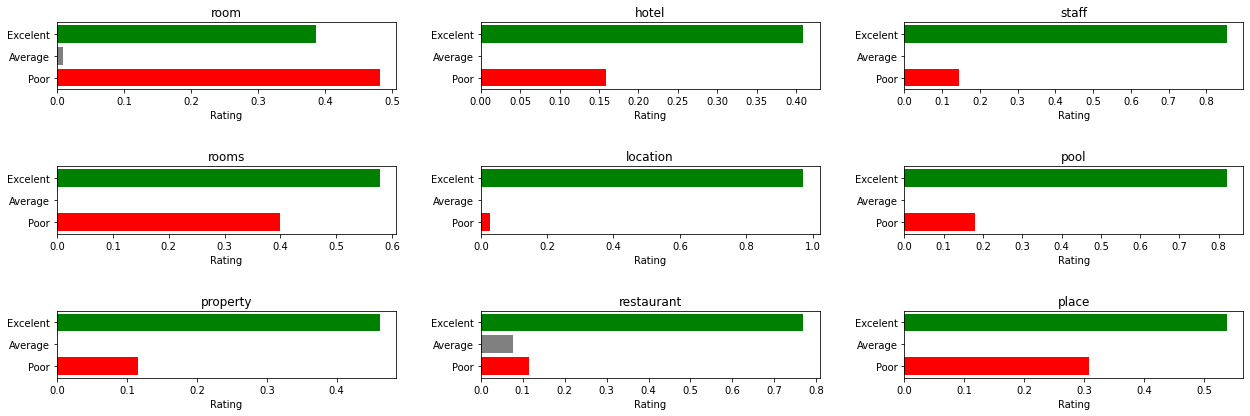

In [21]:
#Plotting the rating of top aspects detected.
plt.figure(figsize=(18,10))
all_top_aspects=[]
no_of_top_aspects=9
for i in range(no_of_top_aspects):
    asp = top_aspects.iloc[i]['Aspect']
    temp = aspects_frame[aspects_frame['Aspect']==top_aspects.iloc[i]['Aspect']]
    tot_count = temp.count().Aspect
    exce = temp[temp['Sentiment']=='Positive'].count().Aspect/tot_count
    poor = temp[temp['Sentiment']=='Negative'].count().Aspect/tot_count
    avrg = temp[temp['Sentiment']=='Neutral'].count().Aspect/tot_count
    plt.subplot(5, 3, i+1)
    y=['Poor', 'Average', 'Excelent']
    x=[poor,avrg,exce]
    plt.barh(y, x, color=['red', 'grey', 'green'])
    plt.xlabel("Rating") 
    plt.title(asp)
plt.tight_layout(pad=3.0)
plt.show()

### Find aspect with strongest positive and negative polarity

In [22]:
# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
top_aspects = (aspects_frame.groupby(by=['Aspect', 'Sentiment'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

#Top Positive Aspects
no_of_top_aspects=5
top_aspects_positive = top_aspects[top_aspects['Sentiment'] == 'Positive']
top_aspects_positive.iloc[:no_of_top_aspects,:]


,Aspect,Sentiment,Frequency
1,staff,Positive,47
2,room,Positive,41
4,hotel,Positive,36
5,location,Positive,35
6,rooms,Positive,26


In [23]:
#Top Negative Aspects
no_of_top_aspects=5
top_aspects_negative = top_aspects[top_aspects['Sentiment'] == 'Negative']
top_aspects_negative.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
0,room,Negative,51
10,rooms,Negative,18
14,hotel,Negative,14
22,breakfast,Negative,9
24,place,Negative,8


## Display word clouds using sentiment and frequency

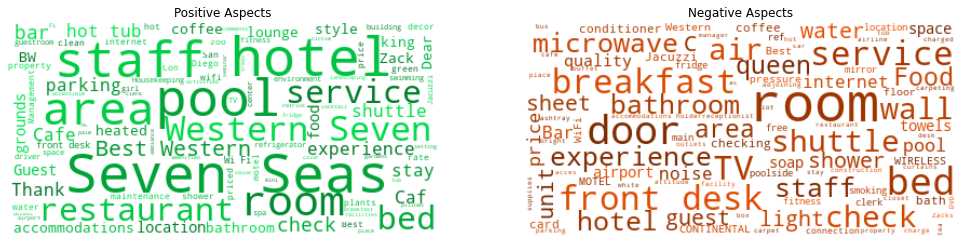

In [24]:
content_pos=''
content_neg=''
for i in top_aspects_positive['Aspect'][0:len(top_aspects_positive['Aspect'])+1]:
    content_pos = content_pos + i + " "
for i in top_aspects_negative['Aspect'][0:len(top_aspects_negative['Aspect'])+1]:
    content_neg = content_neg + i + " "
    
colour_dict = {
    'green':140,
    'blue': 220,
    'red': 20
}
def red_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['red'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
def green_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['green'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#Plotting Word Cloud
from wordcloud import WordCloud, STOPWORDS
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= green_fn).generate(content_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= red_fn).generate(content_neg)
plt.figure(figsize=(17,14))
# plt.figure()
plt.subplot(1, 2, 1)
plt.title("Positive Aspects")
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Negative Aspects")
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()